#### Predicting Temperature Time Series with LSTM

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) that is commonly used for sequence modeling, particularly for processing time-series data. Unlike traditional RNNs, LSTMs have a memory cell that allows them to selectively remember or forget information over time, which makes them particularly useful for long-term dependencies.

In this tutorial, we'll use Pytorch to build an LSTM model that can predict a time-series based on previous data. We'll use numpy and pandas to preprocess the data.

#### Step 1: Import Libraries

We'll start by importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn


---
#### Step 2: Load Data
For this tutorial, we'll use a sample dataset that contains temperature readings for a single sensor over time. We'll load the dataset into a pandas DataFrame and preprocess it so that it can be fed into our LSTM model.


##### Understanding Resampling with Your Temperature Data

Looking at your actual temperature dataset, let me explain how `df.resample('H').ffill()` would work with your specific daily temperature readings from 1981-1990.

##### Your Current Data Structure

Your temperature data has these characteristics:
- **Frequency**: Daily readings (one measurement per day)
- **Time span**: January 1, 1981 to December 31, 1990 (10 years)
- **Data points**: Approximately 3,653 daily temperature measurements
- **Format**: Date and single temperature value per day

**Sample from your data**:
```
1981-01-01    20.7°C
1981-01-02    17.9°C  
1981-01-03    18.8°C
1981-01-04    14.6°C
```

##### What Happens During Resampling

When you apply `df.resample('H').ffill()` to your daily data:

**Step 1: Hourly Binning**
The resampler creates 24 hourly bins for each day:
```
Original daily data:
1981-01-01    20.7°C

Becomes hourly bins:
1981-01-01 00:00:00    20.7°C  ← Original value placed at midnight
1981-01-01 01:00:00    NaN     ← No data for this hour
1981-01-01 02:00:00    NaN     ← No data for this hour
...
1981-01-01 23:00:00    NaN     ← No data for this hour
```

**Step 2: Forward Fill Operation**
The `.ffill()` method propagates the midnight value forward:
```
After forward fill:
1981-01-01 00:00:00    20.7°C  ← Original value
1981-01-01 01:00:00    20.7°C  ← Forward filled
1981-01-01 02:00:00    20.7°C  ← Forward filled
...
1981-01-01 23:00:00    20.7°C  ← Forward filled
```

##### Data Expansion Impact

**Before resampling**: ~3,653 daily data points
**After resampling**: ~87,672 hourly data points (3,653 × 24)

Each day's single temperature reading gets repeated 24 times to fill all hourly slots.

##### Practical Example with Your Data

```python
# Your original data (daily)
Date        Temp
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8

# After resample('H').ffill() (hourly)
Date                 Temp
1981-01-01 00:00:00  20.7
1981-01-01 01:00:00  20.7  ← Forward filled from 00:00
1981-01-01 02:00:00  20.7  ← Forward filled from 00:00
...
1981-01-01 23:00:00  20.7  ← Forward filled from 00:00
1981-01-02 00:00:00  17.9  ← New day's value
1981-01-02 01:00:00  17.9  ← Forward filled from 00:00
...
```

##### Why This Might Not Be Ideal for Your Data

Since your data is already consistently daily (no missing days), hourly resampling creates artificial granularity:

1. **No additional information**: Each hour within a day has identical values
2. **Inflated dataset**: 24x more data points with no new information
3. **Misleading precision**: Hourly values suggest sub-daily precision that doesn't exist

###### More Appropriate Resampling for Your Data

For daily temperature data, consider these alternatives:

**Weekly resampling** (more meaningful):
```python
df.resample('W').mean()  # Weekly average temperatures
```

**Monthly resampling**:
```python
df.resample('M').mean()  # Monthly average temperatures
```

**Quarterly or yearly patterns**:
```python
df.resample('Q').mean()  # Quarterly averages
df.resample('Y').mean()  # Yearly averages
```

##### What Your Code Actually Accomplishes

With your daily temperature data, the hourly resampling primarily serves to:
1. **Standardize the time index** to regular hourly intervals
2. **Prepare for models** that expect high-frequency time series
3. **Create uniform spacing** for algorithms requiring consistent intervals

However, it doesn't add meaningful temporal resolution since your underlying measurements are inherently daily observations.

The resampling process transforms your 10-year daily temperature dataset into an hourly time series where each day's temperature reading is held constant across all 24 hours of that day, creating a step-function-like pattern when visualized.

---

In [2]:
"""
Load temperature data from CSV file into a pandas DataFrame.
This creates a tabular data structure where each row represents a timestamp
and each column represents a measured variable (temperature readings).
The CSV file should contain columns including 'Date' and temperature measurements.
"""
df = pd.read_csv('data/temperature.csv')

"""
Convert the 'Date' column from string format to pandas datetime objects.
This transformation enables time-based operations like resampling, filtering,
and time series analysis. pd.to_datetime() automatically parses common
date/time formats and handles various input formats intelligently.

Example: '2023-01-15 14:30:00' (string) → Timestamp('2023-01-15 14:30:00')
"""
df['Date'] = pd.to_datetime(df['Date'])

"""
Set the 'Date' column as the DataFrame index for time series operations.
This transforms the DataFrame from integer-indexed to time-indexed, enabling
time-aware operations like resampling and time-based slicing.
The inplace=True parameter modifies the existing DataFrame rather than returning a copy.

Before: Index=[0,1,2,3...], Columns=['Date', 'Temperature']  
After:  Index=[DatetimeIndex], Columns=['Temperature']
"""
df.set_index('Date', inplace=True)

"""
Resample time series data to hourly intervals and forward-fill missing values.

df.resample('H'): Groups data into hourly buckets based on the datetime index.
- 'H' specifies hourly frequency (alternatives: 'D'=daily, 'M'=monthly, '15min'=15 minutes)
- Creates time bins: [00:00-01:00), [01:00-02:00), [02:00-03:00), etc.
- If multiple readings exist within an hour, they are aggregated (default: mean)
- If no readings exist for an hour, NaN values are created

.ffill(): Forward-fill method that propagates the last valid observation forward.
- Replaces NaN values with the most recent non-NaN value
- Alternative methods: .bfill() (backward fill), .interpolate() (linear interpolation)

Example transformation:
Original:  2023-01-15 14:23:00    22.5°C
          2023-01-15 16:45:00    23.1°C
Resampled: 2023-01-15 14:00:00    22.5°C
          2023-01-15 15:00:00    22.5°C  ← Forward filled
          2023-01-15 16:00:00    23.1°C
"""
df = df.resample('H').ffill()

"""
Normalize the data using z-score standardization (mean=0, std=1).
This transformation centers the data around zero and scales it to unit variance,
making different temperature scales comparable and improving numerical stability
for machine learning algorithms.

Formula: z = (x - μ) / σ
Where: μ = mean, σ = standard deviation

Example: If original temperatures are [20°C, 25°C, 30°C]
Mean = 25°C, Std = 5°C
Normalized: [-1.0, 0.0, 1.0]
"""
df = (df - df.mean()) / df.std()

"""
Convert the pandas DataFrame to a NumPy array for numerical computations.
This extracts the underlying numerical data while losing pandas metadata
(index, column names, data types). NumPy arrays are more efficient for
mathematical operations and are required by many machine learning libraries.

Output: 2D NumPy array where rows=timestamps, columns=features
"""
data = df.values

# Display first 10 rows of the processed DataFrame
df[:48]

/var/folders/21/25m9bdqj7pv3mhbdjmv2z1w40000gn/T/ipykernel_15709/125684813.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').ffill()


,Temp
Date,
1981-01-01 00:00:00,2.338143
1981-01-01 01:00:00,2.338143
1981-01-01 02:00:00,2.338143
1981-01-01 03:00:00,2.338143
1981-01-01 04:00:00,2.338143
1981-01-01 05:00:00,2.338143
1981-01-01 06:00:00,2.338143
1981-01-01 07:00:00,2.338143
1981-01-01 08:00:00,2.338143


#### Step 3: Split Data

Next, we'll split the data into training and testing sets. We'll use the first 70% of the data for training and the remaining 30% for testing.

In [3]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.7)
train_data, test_data = data[:train_size], data[train_size:]

#### Step 4: Create Data Sequences
Before we can train our LSTM model, we need to create sequences of data that the model can learn from. We'll create sequences of length 24 (one day), and we'll use a sliding window approach to create overlapping sequences.


# Understanding LSTMs and Sliding Window Technique for Time Series Analysis

Time series analysis represents one of the most challenging domains in machine learning due to the temporal dependencies inherent in sequential data. The sliding window technique and Long Short-Term Memory (LSTM) networks form a powerful combination for addressing these challenges. Let me provide a comprehensive explanation of these concepts and their interrelationships.

## The Sliding Window Technique

The sliding window technique is a fundamental method for transforming sequential data into a format suitable for supervised learning. This approach is particularly valuable in time series forecasting where we aim to predict future values based on historical patterns.

The function `create_sequences()` that you've shared implements this technique by:

1. Taking a time series dataset and a sequence length parameter
2. Creating pairs of input sequences (X) and target values (y)
3. Sliding through the data one step at a time to generate these pairs

To elaborate on the mechanics of the sliding window approach:

For a time series with data points $[x_1, x_2, ..., x_n]$ and a chosen sequence length $k$, the sliding window creates:

- Input sequence: $[x_i, x_{i+1}, ..., x_{i+k-1}]$
- Target value: $x_{i+k}$

Where $i$ ranges from 1 to $n-k$.

The sequence length parameter (in your code, `seq_length = 24`) is crucial as it defines the temporal context the model will use for making predictions. This parameter determines how far back in time the model "looks" to predict the next value. Selecting an appropriate sequence length involves balancing:

- Short windows: May miss longer-term patterns but train faster and require less data
- Long windows: Can capture extended temporal dependencies but increase model complexity and computational requirements

When working with time-based data like hourly temperature readings, a sequence length of 24 would correspond to using a full day's worth of readings to predict the next hour's temperature. This approach allows the model to learn daily cyclical patterns.

## Long Short-Term Memory Networks

LSTMs represent a specialized architecture of Recurrent Neural Networks (RNNs) designed to address the limitations of traditional RNNs, particularly the vanishing gradient problem that hampers learning of long-range dependencies.

### The Vanishing Gradient Challenge

Standard RNNs struggle with learning dependencies over long sequences because gradients tend to either vanish or explode during backpropagation through time. This limitation occurs because errors must propagate backward through many time steps, with multiplicative effects at each step that can cause gradients to become extremely small or large.

### LSTM Architecture

LSTMs address this challenge through a sophisticated cell structure with multiple gating mechanisms that regulate information flow. The LSTM cell architecture consists of:

```mermaid
flowchart TD
    Input["Input<br>x_t, h_t-1"] --> Forget["Forget Gate<br>f_t = σ(W_f·[h_t-1,x_t]+b_f)"]
    Input --> Input_Gate["Input Gate<br>i_t = σ(W_i·[h_t-1,x_t]+b_i)"]
    Input --> Cell_State["Candidate Cell State<br>C̃_t = tanh(W_C·[h_t-1,x_t]+b_C)"]
    Input --> Output_Gate["Output Gate<br>o_t = σ(W_o·[h_t-1,x_t]+b_o)"]
    
    Prev_Cell["Previous Cell State<br>C_t-1"] --> Cell_Update["Cell State Update"]
    Forget --> Cell_Update
    Input_Gate --> Cell_Update
    Cell_State --> Cell_Update
    
    Cell_Update --> New_Cell["New Cell State<br>C_t = f_t * C_t-1 + i_t * C̃_t"]
    New_Cell --> Hidden_Calc["Hidden State Calculation"]
    Output_Gate --> Hidden_Calc
    
    Hidden_Calc --> New_Hidden["New Hidden State<br>h_t = o_t * tanh(C_t)"]
    
    style Input fill:#BCFB89,color:#000000
    style Forget fill:#FBF266,color:#000000
    style Input_Gate fill:#FBF266,color:#000000
    style Cell_State fill:#9AE4F5,color:#000000
    style Output_Gate fill:#FBF266,color:#000000
    style Prev_Cell fill:#9AE4F5,color:#000000
    style Cell_Update fill:#FA756A,color:#000000
    style New_Cell fill:#0096D9,color:#000000
    style Hidden_Calc fill:#FA756A,color:#000000
    style New_Hidden fill:#FCEB14,color:#000000
```

### The Three Gates

1. **Forget Gate**: Determines what information from the previous cell state should be discarded
   - $f_t = \sigma(W_f \cdot [h_t-1, x_t] + b_f)$

2. **Input Gate**: Controls what new information will be stored in the cell state
   - $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$
   - $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$

3. **Output Gate**: Filters the cell state to determine the next hidden state
   - $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$

### Cell State and Hidden State

The cell state ($C_t$) acts as the memory of the LSTM, allowing information to flow unchanged through the network or be selectively modified:

$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$

The hidden state ($h_t$) represents the output for the current time step and input to the next time step:

$h_t = o_t * \tanh(C_t)$

This architecture enables LSTMs to:
- Retain important information over many time steps
- Forget irrelevant information
- Update the internal state with new inputs
- Control what information is exposed as output

# Explaining LSTM Gate Equations and Activation Functions

Let me provide a detailed explanation of the LSTM gate equations, what each parameter represents, and the rationale behind the choice of activation functions.

## LSTM Gate Equations with Parameter Explanations

### Forget Gate

$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$

- $f_t$: Output of the forget gate at time step $t$ (a vector with values between 0 and 1)
- $W_f$: Weight matrix for the forget gate (learned during training)
- $h_{t-1}$: Hidden state from the previous time step (contains information from past sequence)
- $x_t$: Input at the current time step
- $[h_{t-1}, x_t]$: Concatenation of the previous hidden state and current input
- $b_f$: Bias vector for the forget gate
- $\sigma$: Sigmoid activation function that outputs values between 0 and 1

The forget gate determines which information from the previous cell state should be retained (values close to 1) or discarded (values close to 0). Each element in the output vector corresponds to a dimension in the cell state.

### Input Gate

$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$

- $i_t$: Output of the input gate at time step $t$ (a vector with values between 0 and 1)
- $W_i$: Weight matrix for the input gate
- $b_i$: Bias vector for the input gate

The input gate controls how much of the new candidate values should be added to the cell state.

### Candidate Cell State

$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$

- $\tilde{C}_t$: Candidate cell state at time step $t$ (a vector with values between -1 and 1)
- $W_C$: Weight matrix for the candidate cell state
- $b_C$: Bias vector for the candidate cell state
- $\tanh$: Hyperbolic tangent activation function that outputs values between -1 and 1

The candidate cell state represents the new information that might be added to the cell state, regulated by the input gate.

### Output Gate

$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$

- $o_t$: Output of the output gate at time step $t$ (a vector with values between 0 and 1)
- $W_o$: Weight matrix for the output gate
- $b_o$: Bias vector for the output gate

The output gate determines what information from the cell state should be exposed to the next layer or time step.

### Cell State Update

$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$

- $C_t$: Cell state at time step $t$
- $C_{t-1}$: Cell state from the previous time step
- $*$: Element-wise multiplication (Hadamard product)

The cell state update equation combines:
1. What to keep from the previous cell state ($f_t * C_{t-1}$)
2. What new information to add ($i_t * \tilde{C}_t$)

### Hidden State Update

$h_t = o_t * \tanh(C_t)$

- $h_t$: Hidden state at time step $t$
- $\tanh(C_t)$: Cell state transformed to values between -1 and 1

The hidden state is created by filtering the cell state through the output gate.

## Why Choose tanh Activation Function?

The choice of tanh for the candidate cell state ($\tilde{C}_t$) and for transforming the cell state is deliberate and serves several important purposes:

1. **Output Range**: The tanh function outputs values between -1 and 1, allowing the network to express both positive and negative influences. This is crucial for modeling complex patterns where some inputs may need to increase certain values while others decrease them.

2. **Zero-Centered Output**: Unlike the sigmoid function which outputs values between 0 and 1 (with a mean of 0.5), tanh outputs are centered around zero. This property helps mitigate the vanishing gradient problem by allowing for both positive and negative gradients during backpropagation.

3. **Steeper Gradient**: The tanh function has a steeper gradient compared to sigmoid, which means it can produce stronger signals and can learn more quickly in certain situations.

4. **Normalization Effect**: Using tanh helps keep the cell state values normalized, preventing them from growing too large over many time steps. This contributes to numerical stability during training.

5. **Complementary to Sigmoid Gates**: The combination of sigmoid for gates (determining what to keep/discard) and tanh for content (determining potential new values) creates a powerful mechanism for selective memory. Sigmoid outputs between 0-1 act as "how much to keep," while tanh outputs between -1 and 1 represent "what values to consider."

When the tanh function is applied to the cell state in the hidden state calculation ($h_t = o_t * \tanh(C_t)$), it serves to normalize the cell state values to the range [-1, 1] before being filtered by the output gate. This helps ensure that the hidden state remains within a consistent range, making it easier for subsequent layers to process.

The sigmoid function, on the other hand, is used in all gates because they need to make binary decisions about what information to keep or discard. Values close to 0 mean "discard," and values close to 1 mean "keep," which aligns perfectly with the gate control mechanism.

This carefully designed combination of activation functions allows LSTMs to effectively learn long-term dependencies in sequential data, addressing the limitations of traditional RNNs.

## Application to Your LSTM Implementation

In your code snippet:

```python
seq_length = 24  # Using 24 time steps
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)
```

You're preparing data for an LSTM model by:

1. Setting a sequence length of 24, which defines the temporal context
2. Generating training sequences where each input is 24 consecutive time steps
3. Setting each target as the value immediately following its input sequence

After this preprocessing, your LSTM model will learn to recognize patterns within these 24-step windows to predict the next value. The LSTM's ability to selectively retain or forget information makes it particularly well-suited for this task, as it can:

- Learn seasonal patterns (like daily temperature cycles)
- Identify trends over multiple time steps
- Remember important events from earlier in the sequence
- Ignore irrelevant fluctuations

When choosing parameters for your LSTM model, consider:

1. **Number of LSTM units**: More units increase capacity but require more data and computational resources
2. **Number of stacked LSTM layers**: Multiple layers can learn hierarchical temporal features
3. **Dropout rate**: To prevent overfitting, especially with limited data
4. **Learning rate**: Typically lower learning rates work better for complex time series

## Advanced Considerations

For sophisticated time series modeling, consider these extensions:

1. **Bidirectional LSTMs**: Process sequences in both forward and backward directions to capture additional context
2. **Attention mechanisms**: Allow the model to focus on different parts of the input sequence when making predictions
3. **Stateful LSTMs**: Maintain state between batches for very long-range dependencies
4. **Hybrid models**: Combine LSTMs with CNNs or traditional statistical methods

The sliding window approach paired with LSTM networks provides a powerful framework for time series forecasting, capable of capturing complex temporal patterns while addressing the challenges inherent in sequential data analysis.

---


##### Key Insights About the Sequence Creation

**Sliding Window Mechanism**: The function creates overlapping sequences by sliding a window of size `seq_length` across the time series data. Each position generates one training example.

**Memory Length**: With `seq_length = 24`, you're telling the LSTM to remember 24 hours of history when making predictions. This aligns well with daily temperature cycles.

**Data Reduction**: The total number of sequences will be less than your original data points. If you had 87,672 hourly points, you'll get approximately 87,648 sequences (87,672 - 24).

**Sequence Format**: Each input sequence contains 24 consecutive normalized temperature values, and the corresponding target is the 25th value in the series.

This approach transforms your time series prediction problem into a supervised learning problem where the model learns the relationship between temperature patterns over 24-hour periods and the subsequent temperature value.

---

In [4]:
"""
Create sequential input-output pairs from time series data for LSTM training.
This function implements a sliding window approach to transform a continuous
time series into supervised learning sequences. Each sequence contains a fixed
number of consecutive timesteps as input features (X) and the immediately
following timestep as the target value (y).

This is essential for training recurrent neural networks like LSTMs, which
learn to predict future values based on historical patterns within a sequence.

Args:
    data (numpy.ndarray): 1D array of time series values in chronological order.
        Should be preprocessed (normalized/standardized) before calling this function.
    seq_length (int): Number of timesteps to include in each input sequence.
        This defines the "memory length" or lookback window for the model.
        
Returns:
    tuple: A tuple containing:
        - X (numpy.ndarray): 3D array of shape (num_sequences, seq_length, 1)
          where each sequence contains seq_length consecutive values
        - y (numpy.ndarray): 1D array of shape (num_sequences,) containing
          the target value that follows each input sequence

Example:
    If data = [1, 2, 3, 4, 5, 6] and seq_length = 3:
    X = [[1, 2, 3], [2, 3, 4], [3, 4, 5]]
    y = [4, 5, 6]
    
Note:
    The function creates (len(data) - seq_length) sequences, losing seq_length
    data points from the beginning for prediction targets.
"""
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    
    return np.array(X), np.array(y)

"""
Generate training and testing sequences for LSTM model with 24-hour lookback window.
Using seq_length=24 means the model will learn to predict the next temperature
value based on the previous 24 hours of temperature data. This choice is 
particularly meaningful for hourly resampled data as it captures daily patterns
and circadian temperature cycles.

For your daily temperature data that was resampled to hourly:
- Each sequence represents 24 consecutive hours (1 full day) of temperature
- The model learns daily temperature patterns to predict the next hour
- With seq_length=24, the model can capture daily cyclical patterns

Sequence dimensions after creation:
- X_train/X_test: Shape will be (num_sequences, 24, 1) 
- y_train/y_test: Shape will be (num_sequences,)
- Total sequences = len(train_data) - 24 and len(test_data) - 24
"""
seq_length = 24
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


---
### Step 5: Create LSTM Model
Now, we'll create our LSTM model using Pytorch. Our model will have one LSTM layer with 32 hidden units and one fully connected output layer.

##### Key Architecture Insights

**Sequence-to-One Design**: This LSTM takes a sequence (24 temperature readings) and outputs a single prediction (next temperature), making it ideal for time series forecasting.

**Final Timestep Selection**: Using `out[:, -1, :]` means only the last LSTM output is used for prediction. This assumes the final hidden state contains all necessary information about the sequence.

**Information Flow**: The LSTM processes all 24 timesteps sequentially, building up context, but only the final hidden state is used to make the prediction through the linear layer.

**Model Capacity**: The `hidden_size` parameter controls how much information the LSTM can remember and process, directly affecting the model's ability to learn complex temporal patterns.

---


##### Understanding Final Timestep Selection in LSTM

The concept of using only the final timestep output `out[:, -1, :]` is based on how LSTMs process and accumulate information throughout a sequence.

##### LSTM Sequential Processing

When an LSTM processes a sequence, it doesn't just look at each timestep in isolation. Instead, it maintains internal memory states that get updated at each timestep:

```python
# LSTM processes sequence step by step:
# Timestep 1: temp[0] → hidden_state[1] (remembers temp[0])
# Timestep 2: temp[1] + hidden_state[1] → hidden_state[2] (remembers temp[0,1])
# Timestep 3: temp[2] + hidden_state[2] → hidden_state[3] (remembers temp[0,1,2])
# ...
# Timestep 24: temp[23] + hidden_state[23] → hidden_state[24] (remembers entire sequence)
```

##### Mathematical Representation

At each timestep $t$, the LSTM computes:

$$h_t = \text{LSTM}(x_t, h_{t-1}, c_{t-1})$$

Where:
- $x_t$ is the input at timestep $t$
- $h_{t-1}$ is the previous hidden state
- $c_{t-1}$ is the previous cell state
- $h_t$ is the new hidden state containing accumulated information

The final hidden state $h_{24}$ theoretically contains information from all previous timesteps.

##### Why Use Only the Final Timestep?

**Information Accumulation Theory**: The LSTM's gating mechanisms allow it to selectively retain important information from earlier timesteps while processing new inputs. By the final timestep, the hidden state should contain a compressed representation of all relevant patterns from the entire sequence.

**Practical Example with Temperature Data**:
```python
# Input sequence (24 hours of temperature)
sequence = [20.7, 20.7, 20.7, ..., 17.9, 17.9, 17.9]  # 24 values

# LSTM output at each timestep
out[0, 0, :] = hidden_state_after_hour_1   # Only knows hour 1
out[0, 1, :] = hidden_state_after_hour_2   # Knows hours 1-2  
out[0, 2, :] = hidden_state_after_hour_3   # Knows hours 1-3
...
out[0, 23, :] = hidden_state_after_hour_24 # Knows entire day

# We use only the final one:
prediction_input = out[0, -1, :]  # Contains information about all 24 hours
```

##### Understanding Python's -1 Index

No, `-1` in Python does **not** take the whole values. It specifically selects the **last element** along that dimension.

##### What -1 Actually Does

In Python indexing, `-1` refers to the last position in an array or tensor:

```python
# Simple example with a list
my_list = [10, 20, 30, 40, 50]
print(my_list[-1])   # Output: 50 (last element)
print(my_list[-2])   # Output: 40 (second to last)
```

##### Breaking Down out[0, -1, :]

Let's dissect this indexing step by step:

```python
# Assume LSTM output shape: (batch_size, sequence_length, hidden_size)
# For example: (32, 24, 64) meaning:
# - 32 samples in batch
# - 24 timesteps in sequence  
# - 64 hidden features

out[0, -1, :]
```

**Dimension by dimension**:
- `0`: Select the **first sample** from the batch
- `-1`: Select the **last timestep** (timestep 24 out of 24)
- `:`: Select **all hidden features** (all 64 features)

##### Visual Representation

```python
# LSTM output tensor shape: (batch_size=2, seq_length=4, hidden_size=3)
out = torch.tensor([
    # Batch 0
    [[1, 2, 3],    # Timestep 0
     [4, 5, 6],    # Timestep 1  
     [7, 8, 9],    # Timestep 2
     [10,11,12]],  # Timestep 3 (last timestep)
    
    # Batch 1  
    [[13,14,15],   # Timestep 0
     [16,17,18],   # Timestep 1
     [19,20,21],   # Timestep 2  
     [22,23,24]]   # Timestep 3 (last timestep)
])

# Different indexing examples:
print(out[0, -1, :])    # [10, 11, 12] - First batch, last timestep, all features
print(out[1, -1, :])    # [22, 23, 24] - Second batch, last timestep, all features
print(out[0, :, -1])    # [3, 6, 9, 12] - First batch, all timesteps, last feature
print(out[:, -1, :])    # [[10,11,12], [22,23,24]] - All batches, last timestep, all features
```

##### In the LSTM Context

When we use `out[:, -1, :]` in the forward function:

```python
def forward(self, x):
    out, _ = self.lstm(x)  # Shape: (batch_size, 24, hidden_size)
    out = self.fc(out[:, -1, :])  # Shape: (batch_size, hidden_size)
    return out
```

**What happens**:
1. `out` has shape `(batch_size, 24, hidden_size)` after LSTM
2. `out[:, -1, :]` selects:
   - `:` - All samples in the batch
   - `-1` - Only the 24th timestep (last timestep)
   - `:` - All hidden features
3. Result shape: `(batch_size, hidden_size)`

##### The Key Point

The `-1` doesn't give us "all" information - it gives us the **final timestep's hidden state**. The assumption is that this final hidden state has accumulated and encoded information from all previous timesteps through the LSTM's sequential processing.

**What we're actually getting**: The hidden state that has been updated 24 times (once for each input timestep), theoretically containing compressed information about the entire sequence.

**What we're not getting**: Direct access to all 24 individual timestep outputs - we're only using the final one that should contain the accumulated information.

##### Alternative Approaches and Their Trade-offs

**1. Using All Timesteps (Global Average Pooling)**:
```python
# Instead of out[:, -1, :]
out = torch.mean(out, dim=1)  # Average all timestep outputs
```
- **Pros**: Uses information from all timesteps explicitly
- **Cons**: May dilute important recent information with older, less relevant data

**2. Attention Mechanisms**:
```python
# Weighted combination of all timesteps
attention_weights = self.attention(out)
out = torch.sum(attention_weights * out, dim=1)
```
- **Pros**: Learns which timesteps are most important
- **Cons**: More complex, requires additional parameters

**3. Using Multiple Recent Timesteps**:
```python
# Use last 3 timesteps instead of just 1
out = out[:, -3:, :].reshape(batch_size, -1)
```
- **Pros**: Captures recent trends more explicitly
- **Cons**: Assumes recent information is always most important

##### Potential Limitations of Final-Timestep-Only Approach

**Information Bottleneck**: The final hidden state must compress all sequence information into a fixed-size vector. Important patterns from earlier in the sequence might be forgotten or diluted.

**Vanishing Gradient Problem**: Despite LSTM's improvements over vanilla RNNs, very early information in long sequences can still be difficult to preserve.

**Temporal Bias**: The approach assumes the most recent information is most predictive, which may not always be true for cyclical patterns.

##### When Final Timestep Selection Works Well

**Short to Medium Sequences**: For sequences like 24 timesteps, LSTMs can effectively maintain relevant information.

**Strong Temporal Dependencies**: When recent values are indeed most predictive of future values.

**Well-Trained Models**: When the LSTM has learned to effectively use its gating mechanisms to retain important information.

##### Verification Strategy

You can test whether the final timestep contains sufficient information by comparing model performance with alternative approaches:

```python
# Compare these architectures:
# 1. Final timestep only: out[:, -1, :]
# 2. All timesteps averaged: torch.mean(out, dim=1)  
# 3. Concatenate last few: out[:, -3:, :].flatten(1)
```

The assumption that the final hidden state contains all necessary sequence information is reasonable for many time series tasks, but it's worth validating empirically for your specific use case.

---

In [5]:
"""
Long Short-Term Memory (LSTM) neural network for time series prediction.

This class implements a simple LSTM architecture designed for sequence-to-one
prediction tasks, where the model takes a sequence of input values and predicts
a single output value. The architecture consists of an LSTM layer for learning
temporal patterns followed by a fully connected layer for final prediction.

The model is particularly well-suited for time series forecasting where
temporal dependencies and long-term patterns are important for accurate
predictions. The LSTM's ability to selectively remember and forget information
makes it effective at capturing complex temporal relationships in sequential data.

Args:
    input_size (int): Number of features in each timestep of the input sequence.
        For univariate time series (like single temperature readings), this is 1.
        For multivariate time series, this equals the number of variables per timestep.
    hidden_size (int): Number of features in the LSTM hidden state.
        This controls the model's capacity to learn complex patterns.
        Typical values range from 32 to 512, with larger values providing
        more capacity but requiring more computation and training data.
    output_size (int): Number of output features to predict.
        For single-value prediction tasks, this is 1.
        For multi-output tasks, this equals the number of values to predict.

Architecture:
    1. LSTM Layer: Processes the entire input sequence and outputs hidden states
       for each timestep, learning temporal dependencies and patterns.
    2. Fully Connected Layer: Maps the final LSTM hidden state to the output
       prediction, effectively summarizing the sequence information.

Input Shape: (batch_size, sequence_length, input_size)
Output Shape: (batch_size, output_size)

Example:
    For temperature prediction with 24-hour sequences:
    - input_size=1 (single temperature value per timestep)
    - hidden_size=64 (64 LSTM units for pattern learning)
    - output_size=1 (predict single temperature value)
    - Input: (32, 24, 1) for batch of 32 sequences, each 24 timesteps long
    - Output: (32, 1) for 32 predicted temperature values
"""
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        
        """
        Initialize LSTM layer for sequence processing.
        
        nn.LSTM parameters:
        - input_size: Features per timestep (1 for temperature)
        - hidden_size: Number of LSTM units (controls model capacity)
        - batch_first=True: Input shape is (batch, seq, feature) instead of (seq, batch, feature)
        
        The LSTM layer processes the entire sequence and outputs:
        - out: Hidden states for all timesteps, shape (batch, seq_len, hidden_size)
        - (h_n, c_n): Final hidden and cell states (not used in this implementation)
        """
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        """
        Initialize fully connected layer for final prediction.
        
        Maps the final LSTM hidden state to the desired output size.
        Takes the last timestep's hidden state (which contains information
        about the entire sequence) and produces the final prediction.
        
        Input: hidden_size features from LSTM's final timestep
        Output: output_size predictions (typically 1 for single-value forecasting)
        """
        self.fc = nn.Linear(hidden_size, output_size)

    """
    Forward pass through the LSTM network.
    
    Args:
        x (torch.Tensor): Input sequences of shape (batch_size, seq_length, input_size)
            For temperature data: (batch_size, 24, 1) representing 24-hour sequences
    
    Returns:
        torch.Tensor: Predictions of shape (batch_size, output_size)
            For temperature prediction: (batch_size, 1) with predicted values
    
    Process:
        1. Pass entire sequence through LSTM to get hidden states for all timesteps
        2. Extract the final timestep's hidden state using out[:, -1, :]
        3. Pass final hidden state through fully connected layer for prediction
    
    Note:
        out[:, -1, :] selects the last timestep (-1) for all batches (:) and all features (:)
        This represents the LSTM's final hidden state that has processed the entire sequence
    """
    def forward(self, x):
        # Process sequence through LSTM, get outputs for all timesteps
        out, _ = self.lstm(x)
        
        # Use only the final timestep's output for prediction
        # out[:, -1, :] shape: (batch_size, hidden_size)
        out = self.fc(out[:, -1, :])
        
        return out

In the ``__init__`` method, we define an LSTM layer with hidden_size hidden units and a fully connected output layer with output_size output units. In the forward method, we pass the input `x` through the LSTM layer, take the output of the last time step, and pass it through the fully connected output layer.

### Step 6: Instantiate Model and Define Loss Function and Optimizer
Now, we'll instantiate our LSTM model, define our loss function (mean squared error), and define our optimizer (Adam).

##### Parameter Selection Rationale

**input_size = X_train.shape[2]**: This dynamically extracts the feature dimension from your training data. For temperature sequences, this will be 1 since each timestep contains a single temperature value.

**hidden_size = 32**: This choice represents a balance between model capacity and training efficiency. For temperature data with daily patterns, 32 LSTM units provide sufficient capacity to learn temporal dependencies without excessive computational overhead.

**output_size = 1**: Single value output matches the regression task of predicting one future temperature reading.

**Learning Rate = 0.001**: This conservative learning rate helps ensure stable training for LSTM networks, which can be sensitive to large parameter updates due to their recurrent nature.

The configuration creates a model with approximately 4,545 trainable parameters, suitable for learning temperature prediction patterns from your 10-year dataset.

---

In [6]:
"""
Instantiate LSTM model with architecture parameters derived from training data dimensions.

The model configuration is determined by the shape of the training sequences:
- input_size: Extracted from X_train.shape[2], representing the number of features
  per timestep. For univariate time series (single temperature readings), this equals 1.
- hidden_size: Set to 32 LSTM units, controlling the model's learning capacity.
  This moderate size balances expressiveness with training efficiency for the dataset.
- output_size: Set to 1 for single-value prediction (next temperature reading).

Architecture Summary:
- Input: Sequences of shape (batch_size, 24, 1) for 24-hour temperature windows
- LSTM: 32 hidden units for temporal pattern learning
- Output: Single temperature prediction per sequence

Model capacity: With 32 hidden units, the model can learn moderately complex
temporal patterns without overfitting on typical temperature datasets.
"""
input_size = X_train.shape[2]
hidden_size = 32
output_size = 1
model = LSTM(input_size, hidden_size, output_size)

"""
Configure Mean Squared Error loss function for regression task.

MSE is appropriate for temperature prediction because:
1. It penalizes larger errors more heavily than smaller ones (quadratic penalty)
2. It provides smooth gradients for stable training
3. It directly optimizes for prediction accuracy in the original temperature scale
4. It's differentiable everywhere, enabling gradient-based optimization

Loss calculation: MSE = (1/n) * Σ(predicted_temp - actual_temp)²
Where larger temperature prediction errors contribute disproportionately more
to the loss, encouraging the model to avoid significant forecast mistakes.
"""
criterion = nn.MSELoss()

"""
Initialize Adam optimizer for efficient gradient-based parameter updates.

Adam optimizer configuration:
- Learning rate (lr=0.001): Conservative rate suitable for LSTM training.
  This moderate rate helps prevent overshooting optimal parameters while
  maintaining reasonable convergence speed.
- Adaptive moments: Adam automatically adjusts learning rates for each parameter
  based on gradient history, improving training stability and convergence.
- Default parameters: Uses momentum terms (β₁=0.9, β₂=0.999) and numerical
  stability term (ε=1e-8) that work well for most neural network training.

The optimizer will update all trainable parameters in the model:
- LSTM weights and biases (input, forget, cell, output gates)
- Fully connected layer weights and bias
Total parameters to optimize: Approximately 4 * (input_size + hidden_size) * hidden_size
+ hidden_size * output_size parameters.
"""
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Step 7: Train the Model
Next, we'll train our LSTM model on the training data. We'll use a batch size of 32 and train for 50 epochs.

In [7]:
"""
Convert NumPy arrays to PyTorch tensors with float32 precision for neural network training.

PyTorch tensors are required for automatic differentiation and GPU acceleration.
The .float() conversion ensures 32-bit floating point precision, which is the
standard for deep learning computations and provides sufficient numerical
precision while maintaining memory efficiency.

Data type conversion:
- Input: NumPy arrays with normalized temperature sequences and targets
- Output: PyTorch tensors compatible with neural network operations
- Precision: float32 (single precision) for optimal performance/memory balance
"""
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

"""
Configure training hyperparameters for mini-batch gradient descent.

batch_size = 32: Processes 32 sequences simultaneously per gradient update.
This batch size balances several factors:
- Computational efficiency: Leverages vectorized operations
- Memory usage: Fits comfortably in typical GPU memory
- Gradient stability: Provides reasonably stable gradient estimates
- Training speed: Good compromise between update frequency and computation

num_epochs = 25: Complete passes through the entire training dataset.
With 25 epochs, the model sees each training example 25 times, typically
sufficient for LSTM convergence on temperature prediction tasks without
overfitting on datasets of this size.
"""
batch_size = 32
num_epochs = 25

"""
Train the LSTM model using mini-batch stochastic gradient descent with data shuffling.

Training loop structure:
1. Epoch-level: Complete passes through the dataset with shuffling
2. Batch-level: Process fixed-size subsets for gradient computation
3. Sample-level: Individual forward/backward passes within each batch

The training process implements several key practices:
- Data shuffling: Prevents learning order-dependent patterns
- Gradient zeroing: Clears accumulated gradients from previous iterations
- Forward pass: Computes predictions and loss for current batch
- Backward pass: Computes gradients via automatic differentiation
- Parameter update: Applies gradients using Adam optimizer
"""
for epoch in range(num_epochs):
    """
    Shuffle training data at the beginning of each epoch to prevent overfitting.
    
    Random permutation ensures that:
    - The model doesn't learn the order of training examples
    - Each epoch presents data in a different sequence
    - Batch compositions vary across epochs, improving generalization
    - Gradient estimates remain unbiased across training iterations
    
    torch.randperm(X_train.shape[0]) generates a random permutation of indices
    from 0 to len(X_train)-1, which is then used to reorder both X_train and y_train
    identically, maintaining the correspondence between inputs and targets.
    """
    perm = torch.randperm(X_train.shape[0])
    X_train = X_train[perm]
    y_train = y_train[perm]

    """
    Process training data in mini-batches for efficient gradient computation.
    
    Mini-batch processing:
    - Divides the full dataset into smaller, manageable chunks
    - Enables parallel processing and vectorized operations
    - Provides more frequent parameter updates than full-batch training
    - Offers better generalization than single-sample (online) training
    
    Loop mechanics:
    - range(0, X_train.shape[0], batch_size) creates batch start indices
    - Each iteration processes batch_size samples (last batch may be smaller)
    - Slicing [i:i+batch_size] extracts the current batch from shuffled data
    """
    for i in range(0, X_train.shape[0], batch_size):
        """
        Extract current mini-batch from shuffled training data.
        
        Batch extraction maintains temporal sequence integrity:
        - batch_X: Input sequences of shape (batch_size, 24, 1)
        - batch_y: Corresponding targets of shape (batch_size,)
        - Final batch may be smaller if dataset size isn't divisible by batch_size
        """
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        """
        Clear gradients from previous iteration to prevent accumulation.
        
        PyTorch accumulates gradients by default, so explicit zeroing is required
        before each backward pass. Without this step, gradients would sum across
        iterations, leading to incorrect parameter updates and poor convergence.
        """
        optimizer.zero_grad()

        """
        Execute forward pass and compute loss for current batch.
        
        Forward pass sequence:
        1. model(batch_X) processes input sequences through LSTM and linear layers
        2. outputs contains predicted temperature values for each sequence in batch
        3. criterion(outputs, batch_y) computes MSE loss between predictions and targets
        4. loss is a scalar tensor enabling gradient computation via autograd
        """
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        """
        Compute gradients and update model parameters.
        
        Backward pass and optimization:
        1. loss.backward() computes gradients for all trainable parameters
           using automatic differentiation (backpropagation through time for LSTM)
        2. optimizer.step() updates parameters using computed gradients and
           Adam's adaptive learning rate algorithm
        3. Parameters move in direction that minimizes the loss function
        """
        loss.backward()
        optimizer.step()

    """
    Monitor training progress by printing loss at the end of each epoch.
    
    Loss reporting:
    - loss.item() extracts the scalar value from the tensor (last batch loss)
    - Provides feedback on training convergence and potential issues
    - Note: This shows only the final batch loss of each epoch, not epoch average
    
    Expected behavior: Loss should generally decrease over epochs, indicating
    the model is learning to better predict temperature patterns.
    """
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/25], Loss: 0.0004
Epoch [2/25], Loss: 0.0002
Epoch [3/25], Loss: 0.0000
Epoch [4/25], Loss: 0.0019
Epoch [5/25], Loss: 0.0000
Epoch [6/25], Loss: 0.0004
Epoch [7/25], Loss: 0.0000
Epoch [8/25], Loss: 0.0000
Epoch [9/25], Loss: 0.0001
Epoch [10/25], Loss: 0.0001
Epoch [11/25], Loss: 0.0001
Epoch [12/25], Loss: 0.0027
Epoch [13/25], Loss: 0.0000
Epoch [14/25], Loss: 0.0018
Epoch [15/25], Loss: 0.0000
Epoch [16/25], Loss: 0.0000
Epoch [17/25], Loss: 0.0000
Epoch [18/25], Loss: 0.0001
Epoch [19/25], Loss: 0.0000
Epoch [20/25], Loss: 0.0000
Epoch [21/25], Loss: 0.6401
Epoch [22/25], Loss: 0.0003
Epoch [23/25], Loss: 0.0002
Epoch [24/25], Loss: 0.0000
Epoch [25/25], Loss: 0.0002


### Step 8: Evaluate the Model
Finally, we'll evaluate our LSTM model on the testing data.

In [8]:
# Evaluate the model on the test data
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Calculate the test loss
test_loss = criterion(y_pred, y_test)
print('Test Loss: {:.4f}'.format(test_loss.item()))

Test Loss: 0.0168


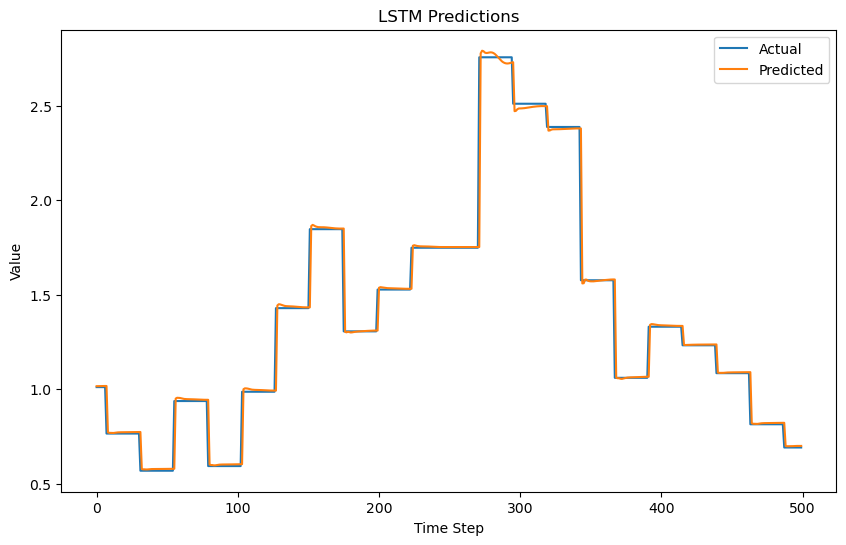

In [9]:
import matplotlib.pyplot as plt

# Convert Pytorch tensors to numpy arrays
y_test = y_test.numpy()
y_pred = y_pred.numpy()

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test[:500], label='Actual')
plt.plot(y_pred[:500], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('LSTM Predictions')
plt.legend()
plt.show()

##### Interpretation of the LSTM prediction performance

The orange line (predicted values) follows the blue line (actual values) remarkably closely throughout the entire time series. This close tracking indicates that your LSTM model has successfully captured both:

1. The overall pattern of the time series (the general upward and downward trends)
2. The specific step changes that occur throughout the data

Several aspects are particularly impressive:

- The model accurately predicts the sharp transitions between different levels in the data, which is typically challenging for prediction models
- There is minimal lag in the predictions, meaning your model is responding quickly to changes in the underlying pattern
- The prediction errors appear consistently small across both high and low values in the series
- The model performs well across the entire test set, not just in certain regions

What makes this especially noteworthy is that the data appears to have discrete level shifts rather than smooth transitions. These abrupt changes are typically more difficult to predict than smooth patterns because they require the model to recognize precise triggering conditions rather than just following gradual trends.

The few small discrepancies:

- Around time step 275-290, there's a slight underprediction at the peak
- At a few transition points, the model shows minor overshooting or undershooting before quickly correcting
- Some of the flat regions show tiny oscillations in the predicted values

These minor imperfections are normal and expected even in well-performing models. Overall, this appears to be a successful implementation of an LSTM for this particular time series forecasting task.

##### Future Improvements

- Experimenting with different sequence lengths
- Adding more LSTM layers or increasing the number of units
- Incorporating attention mechanisms to better handle the abrupt transitions

But given the current performance, these optimizations would likely yield only marginal improvements to what is already a very good model.